# Convolutional Sentiment Classifier #

In this notebook we will build Convolutional NN to classify Sentiments using Keras

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import pandas as pd 
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPool1D, SpatialDropout1D
from keras.layers import Embedding
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import os 
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


**Set Hyperparameter**

In [0]:
output_dir = 'data/conv'

#Training 
epochs = 4
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 5000
max_review_length = 300
pad_type = trunc_type = 'pre'
drop_embed = 0.2

#conv 
n_con = 256
k_con = 3

#NN
n_dense = 256
dropout = 0.2

**Load Data**

In [0]:
(X_train,y_train),(X_valid,y_valid) = imdb.load_data(num_words=n_unique_words)

In [5]:
X_train.shape,y_train.shape

((25000,), (25000,))

In [6]:
X_valid.shape,y_valid.shape

((25000,), (25000,))

**Restoring the word from word index**

In [0]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}

In [0]:
#Manually set the PAD , START, UNK indexes 
word_index['PAD']=0
word_index['START']=1
word_index['UNK']=2

**Preprocess Data**

In [0]:
X_train = pad_sequences(X_train,maxlen=max_review_length,padding=pad_type,value=0)
X_valid = pad_sequences(X_valid,maxlen=max_review_length,padding=pad_type,value=0)

**Design Neural Network**

In [0]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_con,k_con,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1,activation='sigmoid'))


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

**Confihure Model**

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [0]:
# Check if the output dir is present or not
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

**Train :) **

In [15]:
X_valid.shape,y_valid.shape

((25000, 300), (25000,))

In [16]:
# 85.7% validation accuracy in epoch 1
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(X_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 8s 313us/step - loss: 0.4942 - acc: 0.7419 - val_loss: 0.3000 - val_acc: 0.8729
Epoch 2/4
25000/25000 [==============================] - 6s 244us/step - loss: 0.2623 - acc: 0.8936 - val_loss: 0.2704 - val_acc: 0.8866
Epoch 3/4
25000/25000 [==============================] - 6s 243us/step - loss: 0.1778 - acc: 0.9329 - val_loss: 0.2669 - val_acc: 0.8908
Epoch 4/4
21504/25000 [========================>.....] - ETA: 0s - loss: 0.1186 - acc: 0.9602

25000/25000 [==============================] - 6s 245us/step - loss: 0.1191 - acc: 0.9594 - val_loss: 0.2890 - val_acc: 0.8886


In [0]:
model.load_weights(output_dir+"/weights.02.hdf5")

In [0]:
y_hat = model.predict_proba(X_valid)

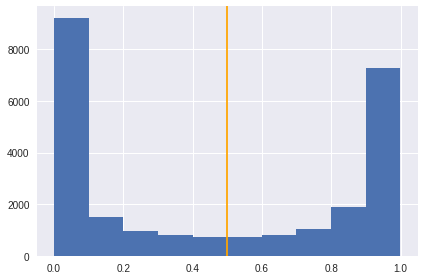

In [19]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')
plt.tight_layout()

**Evaluate the model**

In [0]:
auc = roc_auc_score(y_valid,y_hat)*100

In [21]:
"{:0.2f}".format(auc)

'95.77'